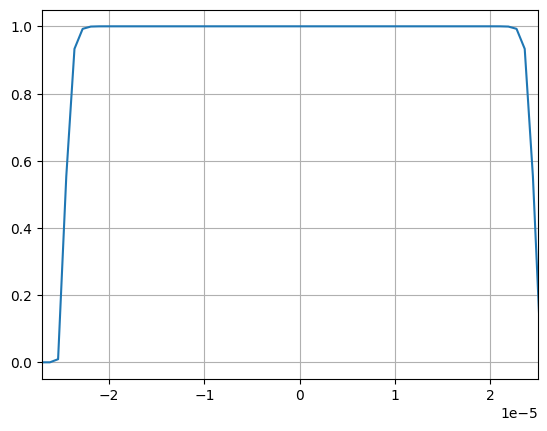

Using downloaded and verified file: /home/lpt/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/lpt/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/lpt/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/lpt/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/lpt/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/lpt/.medmnist/breastmnist.npz
(546, 28, 28)
(156, 28, 28)
(78, 28, 28)
(780, 28, 28)


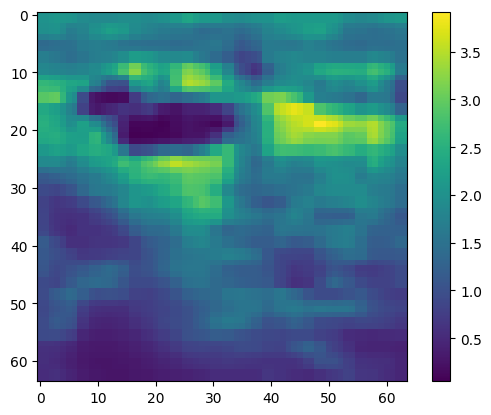

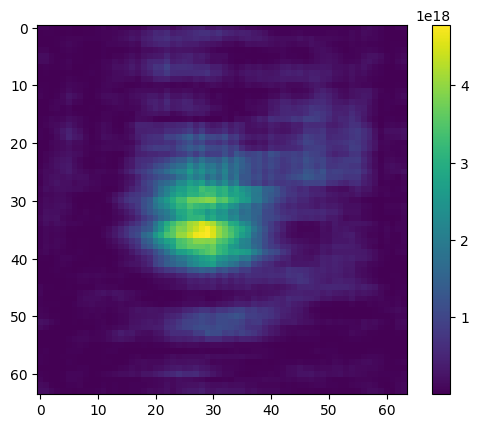

100%|██████████| 780/780 [5:13:39<00:00, 24.13s/it]  
/tmp/ipykernel_3882589/3732790769.py:298: RuntimeWarning: divide by zero encountered in log10
  plt.plot(www*1e9,10*np.log10(np.abs(sf_in)**2),label='Input Spectrum')


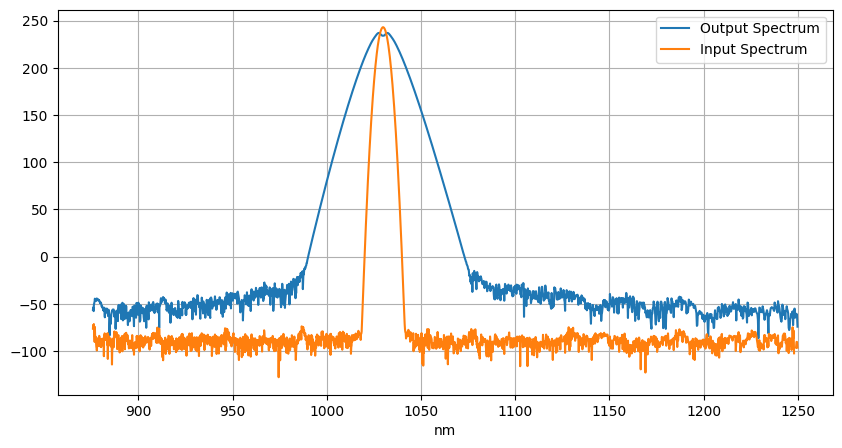

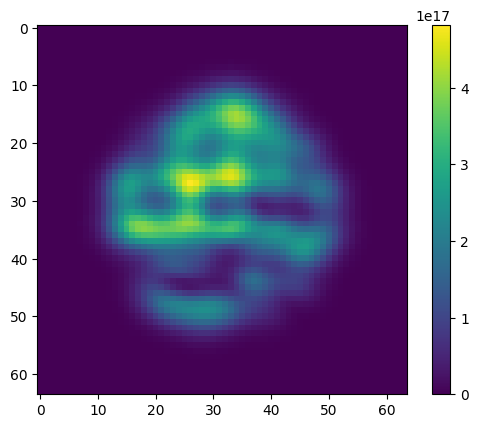

ValueError: Cannot convert from complex128 to float64.

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
import time
from skimage.transform import resize_local_mean
from torchvision import datasets, transforms
from tqdm import trange
import skimage
from scipy.ndimage import gaussian_filter
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#002a51","#0084d1","#83caff","#d9ff19","#eebf00","#ff420e","#7f0006"])

"""# Super Gaussian for boundary"""
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1,p=60,w=25e-6):
  """define normalized 2D gaussian"""

  return np.exp(-2*((np.sqrt(x**2+y**2)/w)**p))

spacewidth=54.1442e-6

xres=54.1442e-6/64
x = np.linspace(-spacewidth*0.5,spacewidth*0.5,int(spacewidth/xres))

x1, y1 = np.meshgrid(x, x) # get 2D variables instead of 1D
z = gaus2d(x1, y1)

plt.plot(x,z[32,:])
plt.grid()
plt.xlim((-27.0721e-6,25e-6))
plt.show()

cp_super_gauss2d =cp.asarray(z)
cp_super_gauss2d = cp.repeat(cp_super_gauss2d[:,:,cp.newaxis], 2048, axis=2) # add temporal axis


#plt.imshow(z)
#plt.colorbar()
#plt.show()
"""# BPM

"""
tt = time.time()
c = 299792458 # [m/s]
n0 = 1.44                   # Refractive index of medium
lambda_c = 1030e-9          # Central wavelength of the input pulse in [m]
#k0 = 2*pi/lambda_c         # [1/m]
#k = k0*n0                  # [1/m]

## TIME SPACE DOMAIN
timewidth = 20e-12          # Width of the time window in [s]
tres = timewidth/((2**11))
t = cp.arange(-timewidth*0.5,(timewidth*0.5),tres)
#t = -timewidth*0.5:tres:timewidth*0.5 # Time in [s]
timesteps=len(t)

spacewidth=54.1442e-6
xres = spacewidth/((2**6))
#x = -spacewidth*0.5:xres:spacewidth*0.5 # Time in [s]
x = cp.arange(-spacewidth*0.5,(spacewidth*0.5),xres)
xsteps=len(x)
y = x
[XMESH,YMESH] = cp.meshgrid(x,y)
[X,Y,T] = cp.meshgrid(x,y,t)

## FOURIER DOMAIN
fs=1/timewidth
freq = c/lambda_c+fs*cp.linspace(-timesteps/2,timesteps/2,num = timesteps)
#freq=c/lambda_c+fs*linspace(-(timesteps-1)/2,(timesteps-1)/2,timesteps) # [Hz]
wave=c/freq # [m]
w=2*cp.pi*c/lambda_c # [Hz]
omegas=2*cp.pi*freq
wt = omegas-w

#kx = 2*pi/xsteps/xres*x;
#kx = 2*pi/xres*x;

#CHECK KX
a = cp.pi/xres  # grid points in "frequency" domain--> {2*pi*(points/mm)}
N = len(x)
zbam = cp.arange(-a,(a-2*a/N)+(2*a/N),2*a/N)
kx = cp.transpose(zbam) # "frequency" domain indexing ky = kx; 
ky = kx
[KX,KY,WT] = cp.meshgrid(kx,ky,wt);
## OPERATORS
k0 = w*n0/c
n2 = 3.2e-20       #Kerr coefficient (m^2/W)
R = 25e-6
beta2 = 24.8e-27
beta3 = 23.3e-42
gamma = (2*cp.pi*n2/(lambda_c))
delta = 0.01

NL1 = -1j*((k0*delta)/(R*R))*((X**2)+(Y**2))

D1 = (0.5*1j/k0)*((-1j*(KX))**2+(-1j*(KY))**2)
D2 = ((-0.5*1j*beta2)*(-1j*(WT))**2)+((beta3/6)*(-1j*(WT))**3)
D = D1 + D2
dz = 555e-6/16
DFR = cp.exp(D*dz/2)

"""# Data Import"""

import medmnist
from medmnist import INFO, Evaluator

data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
t = transforms.ToTensor()
# load the data
train_label = np.array(DataClass(split='train', transform=t, download=download).labels)
test_label = np.array(DataClass(split='test', transform=t, download=download).labels)
val_label = np.array(DataClass(split='val', transform=t, download=download).labels)
labels = np.concatenate((train_label,test_label,val_label))
#labels = np.load("/home/lpt/repos/fyuce21/cifar10 /cifar10_labels.npy", allow_pickle=True)
train_dataset = np.array(DataClass(split='train', transform=t, download=download).imgs)
test_dataset = np.array(DataClass(split='test', transform=t, download=download).imgs)
val_dataset = np.array(DataClass(split='val', transform=t, download=download).imgs)
print(train_dataset.shape)
print(test_dataset.shape)
print(val_dataset.shape)
df = np.concatenate((train_dataset,test_dataset,val_dataset))
#df = np.load("/home/lpt/repos/fyuce21/cifar10 /cifar10_images_gray.npy", allow_pickle=True)
print(df.shape)

plt.imshow(df[100])


dataset = np.ones((len(df),64,64))
for i in range(len(df)):
    dataset[i] = resize_local_mean(df[i],(64,64))
    
dataset *= 2*np.pi
dataset = cp.array(dataset)

""" First sample to check simulation"""
"""# Fiber Propagation """
## INPUT 
flength = 555e-6*10
fstep = flength/dz
x_fwhm = 25e-6
t_fwhm = 1e-12
Ppeak = 3e6 # kW

A = cp.sqrt(Ppeak/(cp.pi*x_fwhm*x_fwhm))*cp.exp( - ((X**2)/(2*(x_fwhm/2.35482)**2)+ (Y**2)/(2*(x_fwhm/2.35482)**2) + (T**2)/(2*(t_fwhm/2.35482)**2)));
focal_length = 500e-6
lens = cp.exp(-1j*k0*(X**2+Y**2)/(2*focal_length))
phivort = cp.angle(XMESH+1j*YMESH)

phasevort = cp.mod((dataset[1]),2*np.pi)
a = phasevort.get()
plt.imshow(a)
plt.colorbar()
plt.show()
phasevort = cp.exp(1j*phasevort)
phasevort = cp.repeat(phasevort[:,:,cp.newaxis], 2048, axis=2)
phasepat =  cp.repeat(dataset[1][:,:,cp.newaxis], 2048, axis=2)
A = A*phasevort
DFRBEF = cp.exp(D1*400e-6)
Einf=cp.fft.fftshift(cp.fft.fftn(A))
A = cp.fft.ifftn(cp.fft.ifftshift(Einf*DFRBEF))
a_cpu = A.get()
ampltd =np.sum(a_cpu,axis=2)
plt.imshow((np.abs(ampltd)**2))
plt.colorbar()
plt.show()

### MAIN FUNCTION
Ain = A
#Asave = cp.zeros((sampesize,64,64,1024), dtype=complex)



"""# Data Processing"""
flengths = [27.75]
meter = [27.75]
mode = ["stable"]
results_ridge = np.ones((len(flengths)))
for idx,state in enumerate(mode):
    for i in range(len(flengths)):
        flength = 1000e-6*flengths[i]
        fstep = flength/dz
        sample_size = len(dataset)
        data_s= np.zeros((sample_size,64,64), dtype = complex)  
        for musti in trange(len(dataset)):
        #for musti in trange(2):
            A = cp.sqrt(Ppeak/(cp.pi*x_fwhm*x_fwhm))*cp.exp( - ((X**2)/(2*(x_fwhm/2.35482)**2)+ (Y**2)/(2*(x_fwhm/2.35482)**2) + (T**2)/(2*(t_fwhm/2.35482)**2)))
            if state == "chaotic":
                phasevort = cp.mod((phivort+dataset[musti]),2*np.pi)
                phasevort = cp.exp(1j*phasevort)
                phasevort = cp.repeat(phasevort[:,:,cp.newaxis], 2048, axis=2)
                phasepat =  cp.repeat(dataset[musti][:,:,cp.newaxis], 2048, axis=2)
                A = A*phasevort
            else:
                phasevort = cp.mod((dataset[musti]),2*np.pi)
                phasevort = cp.exp(1j*phasevort)
                phasevort = cp.repeat(phasevort[:,:,cp.newaxis], 2048, axis=2)
                phasepat =  cp.repeat(dataset[musti][:,:,cp.newaxis], 2048, axis=2)
                A = A*phasevort
            DFRBEF = cp.exp(D1*400e-6)
            Einf=cp.fft.fftshift(cp.fft.fftn(A))
            A = cp.fft.ifftn(cp.fft.ifftshift(Einf*DFRBEF))
            ### MAIN FUNCTION
            Ain = A
            for ugur in range(int(fstep)):
                Einf=cp.fft.fftshift(cp.fft.fftn(Ain));
                Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
                Eout = Ein2;
                    
                NL2 = 1j*gamma*cp.abs(Eout)**2;
                NL = NL1+NL2;
                Eout = Eout*cp.exp(NL*dz);
                    
                Einf=cp.fft.fftshift(cp.fft.fftn(Eout));
                Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
                Ain = Ein2;
                Ain =cp.multiply(cp_super_gauss2d,Ein2);

            
            
            Ain_cpu=Ain.get()  
            sq=(np.squeeze(np.sum(Ain_cpu,axis=2)))
            data_s[musti]=sq
        
        www=wave.get()
        s =np.squeeze(np.sum(np.squeeze(np.sum(Ain_cpu,axis=0)),axis=0))
        s_in =np.squeeze(np.sum(np.squeeze(np.sum(A.get(),axis=0)),axis=0))
        sf=np.fft.fftshift(np.fft.fft(s))
        sf_in=np.fft.fftshift(np.fft.fft(s_in))
        fig=plt.figure(figsize=(10,5))
        plt.plot(www*1e9,10*np.log10(np.abs(sf)**2),label='Output Spectrum')
        plt.plot(www*1e9,10*np.log10(np.abs(sf_in)**2),label='Input Spectrum')
        plt.legend()
        plt.grid()
        plt.xlabel('nm')
        plt.savefig(f"/home/lpt/repos/fyuce21/breast/stable {state}_{flengths[i]}m_spectrum.png")
        plt.show()
        
        ampltd =np.sum(Ain_cpu,axis=2)
        plt.imshow((np.abs(ampltd)**2))
        plt.colorbar()
        plt.savefig(f"/home/lpt/repos/fyuce21/breast/stable {state}_{flengths[i]}m_beamprofile.png")
        plt.show()
        
        np.save(f"/home/lpt/repos/fyuce21/breast/stable {state}_ppeak3_len_{meter[i]}_rawdata.npy",data_s,allow_pickle=False)
        
        # Ridge Classifier
        from sklearn.linear_model import RidgeClassifier
        from sklearn.model_selection import train_test_split
        
        data_fiber = np.ones((sample_size,22,22))
        for ii in range(sample_size):
            data_fiber[ii] = resize_local_mean(data_s[ii],(22,22))
        data_fiber = data_fiber.reshape(sample_size,22*22)
        X_train, X_test, y_train, y_test = train_test_split(data_fiber, labels.ravel(), test_size=0.2, random_state=42)
        X_valtrain, X_valtest, y_train, y_test = train_test_split(df.reshape(sample_size,784), labels.ravel(), test_size=0.2, random_state=42)
        
        classifier = RidgeClassifier()
        cls = RidgeClassifier()
        cls.fit(X_valtrain, y_train)
        y_pred = cls.predict(X_valtest)
        base_acc = cls.score(X_valtest, y_test)
        print(f'State {state}, {flengths[i]}mm, Base Accuracy: {base_acc} \n')
        
        cls = RidgeClassifier()
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_test)
        base_acc = cls.score(X_test, y_test)
        print(f'State {state}, {flengths[i]}mm, Fiber  Accuracy: {base_acc} \n')
        results_ridge[i] = base_acc
    


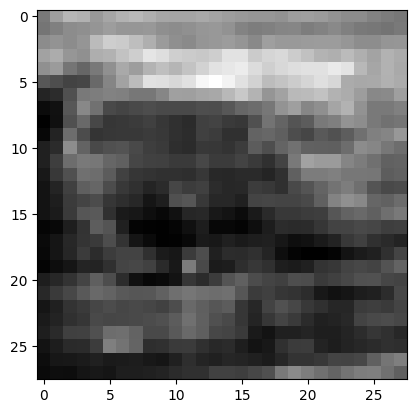

In [58]:
plt.imshow(df[200], cmap = "gray")